### Dataset + show examples with bboxes

torch.Size([18, 2]) torch.Size([18, 10])


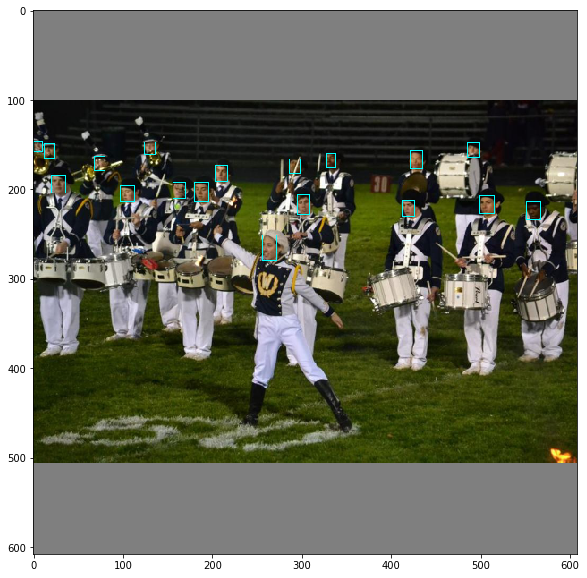

In [21]:
import cv2 
from matplotlib import pyplot as plt
from dataset import WIDERdataset

train_dataset = WIDERdataset('./data/train.json', 'train', 608)

img, targets = train_dataset.__getitem__(40)

for target in targets:
    H, W, C = img.shape
    top_left_x = int(target[2] * W) - int((target[4] * W) // 2)
    top_left_y = int(target[3] * H) - int((target[5] * H) // 2)
    bottom_right_x = int(target[2] * W) + int((target[4] * W) // 2)
    bottom_right_y = int(target[3] * H) + int((target[5] * H) // 2)

    top_left_coords = top_left_x, top_left_y
    # top_left_coords = 100, 200
    bottom_right_coords = bottom_right_x, bottom_right_y
    # bottom_right_coords = 300, 400
    # print(top_left_coords, bottom_right_coords)
    cv2.rectangle(img, top_left_coords, bottom_right_coords, (0, 255, 255), 1)

plt.figure(figsize=(10, 10))
plt.imshow(img)